KEY WORDS: Imputation: NA; Tuning: Bayesian optimization; Selected model: XGB; Metric: roc auc

# Data Source and Description

The data used in this project is from the following link:

https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists

A company provides people with some Data Science courses and is intereted to find out which candidate wants to seek positions of data scientist after these training. The company also wonders what is the factor that motivates the candidates to look for a job.

Here are the features in the given data:

enrollee_id : Unique ID for candidate

city: City code

city_ development _index : Developement index of the city (scaled)

gender: Gender of candidate

relevent_experience: Relevant experience of candidate

enrolled_university: Type of University course enrolled if any

education_level: Education level of candidate

major_discipline :Education major discipline of candidate

experience: Candidate total experience in years

company_size: No of employees in current employer's company

company_type : Type of current employer

lastnewjob: Difference in years between previous job and current job

training_hours: training hours completed

target: 0 – Not looking for job change, 1 – Looking for a job change

# Import Packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.utils import check_array
from scipy import sparse

# Import Training Data

In [ ]:
#train_raw = pd.read_csv("../input/?/train.csv")
#train_raw = pd.read_csv("/Users/shiningdu/Documents/?/train.csv")
#Mount your Google drive so you can read them easilu
from google.colab import drive
drive.mount('/content/gdrive')
train_raw = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/HR Analytics- Job Change of Data Scientists/aug_train.csv")

# What does this data look like?
train_raw.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


Now I check the training data's information.

In [ ]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

This data contain missing values.

# Checking Missing Values

In [ ]:
# to check any missing values in each feature
obs = train_raw.isnull().sum().sort_values(ascending = False)
percent = round(train_raw.isnull().sum().sort_values(ascending = False)/len(train_raw)*100, 2)
pd.concat([obs, percent], axis = 1, keys= ['Number of Observations', 'Percent'])

,Number of Observations,Percent
company_type,6140,32.05
company_size,5938,30.99
gender,4508,23.53
major_discipline,2813,14.68
education_level,460,2.40
last_new_job,423,2.21
enrolled_university,386,2.01
experience,65,0.34
target,0,0.00
training_hours,0,0.00


The missing value percents for the top 4 features are all over 10%! 

In [ ]:
# how many percent of the observations contain at least one missing value?
len(train_raw[train_raw.isna().any(axis=1)])/len(train_raw)

0.5325712496085186

Over 50% of the observations contain  at least one missing value! I can't delete these observations. 

# Missing Value Imputation

It is quite hard to guess why the responders didn't give their answers to the survey, thus I would prefer impute missing values with NA to indicate "unknown" than the mode of each feature.

In [ ]:
train_data = train_raw.copy()

# to replace missing values with new values
train_data['company_type'].fillna('NA_companyType', inplace=True)
train_data['company_size'].fillna('NA_companySize', inplace=True)
train_data['gender'].fillna('NA_gender', inplace=True)
train_data['major_discipline'].fillna('NA_majorDiscipline', inplace=True)
train_data['education_level'].fillna('NA_educationLevel', inplace=True)
train_data['last_new_job'].fillna('NA_lastNewJob', inplace=True)
train_data['enrolled_university'].fillna('NA_enrolledUniversity', inplace=True)
train_data['experience'].fillna('NA_experience', inplace=True)

train_data.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NA_companySize,NA_companyType,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NA_gender,No relevent experience,Full time course,Graduate,STEM,5,NA_companySize,NA_companyType,never,83,0.0
3,33241,city_115,0.789,NA_gender,No relevent experience,NA_enrolledUniversity,Graduate,Business Degree,<1,NA_companySize,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [ ]:
# how many percent of the observations contain at least one missing value NOW?
len(train_data[train_data.isna().any(axis=1)])/len(train_data)

0.0

# Checking Outliers

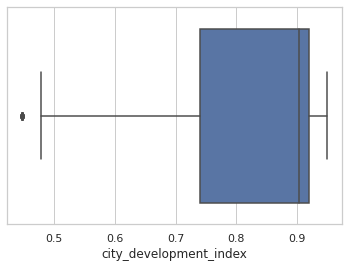

In [ ]:
import seaborn as sns

sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=train_data['city_development_index'])

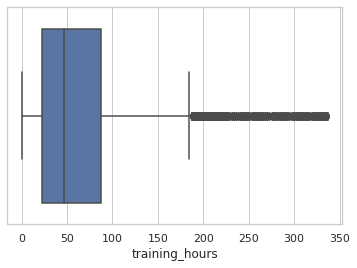

In [ ]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=train_data['training_hours'])

The feature training_hours contains many outliers, I will consider if I keep it after checking feature importance. If I keep it, I'll do log transformation for it.

# Descriptive Analysis

In [ ]:
train_data[['city_development_index',	'training_hours']].describe()

,city_development_index,training_hours
count,19158.000000,19158.000000
mean,0.828848,65.366896
std,0.123362,60.058462
min,0.448000,1.000000
25%,0.740000,23.000000
50%,0.903000,47.000000
75%,0.920000,88.000000
max,0.949000,336.000000


# Categorical Features

Note that the city feature contains values with 'city_', it is better to remove this part for the sake of one hot encoding to be conducted later on.

# Tackling the Feature City 

In [ ]:
import re

train_data2 = train_data.copy()

# to extract the value after "city_" in the city feature
pattern = r'[0-9]+'
regex = re.compile(pattern)
f = lambda x: re.findall(regex, x)[0]    # [0] is used to obtain the value in brakets

train_data2['city'] = train_data2['city'].apply(f)
train_data2.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NA_companySize,NA_companyType,1,36,1.0
1,29725,40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,21,0.624,NA_gender,No relevent experience,Full time course,Graduate,STEM,5,NA_companySize,NA_companyType,never,83,0.0
3,33241,115,0.789,NA_gender,No relevent experience,NA_enrolledUniversity,Graduate,Business Degree,<1,NA_companySize,Pvt Ltd,never,52,1.0
4,666,162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [ ]:
# to drop enrollee_id feature
train_data2 =  train_data2.drop(['enrollee_id'], axis=1)

train_data2.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NA_companySize,NA_companyType,1,36,1.0
1,40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,21,0.624,NA_gender,No relevent experience,Full time course,Graduate,STEM,5,NA_companySize,NA_companyType,never,83,0.0
3,115,0.789,NA_gender,No relevent experience,NA_enrolledUniversity,Graduate,Business Degree,<1,NA_companySize,Pvt Ltd,never,52,1.0
4,162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [ ]:
train_data2.shape

(19158, 13)

# Count of Each Feature

In [ ]:
 # to build a function that counts the number of different values for a feature
def value_count_feature(df, fea):
  count = df[fea].value_counts()
  percent = round(count/len(df[fea])*100, 2)
  return pd.concat([count, percent], axis=1, keys= ['Count', 'Percent'])

L = ['gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job', 'city']

for feature in L:
  print(feature)
  display(value_count_feature(train_data2, feature))   # use display() here, do not use print()!
  print()

gender


,Count,Percent
Male,13221,69.01
NA_gender,4508,23.53
Female,1238,6.46
Other,191,1.00



relevent_experience


,Count,Percent
Has relevent experience,13792,71.99
No relevent experience,5366,28.01



enrolled_university


,Count,Percent
no_enrollment,13817,72.12
Full time course,3757,19.61
Part time course,1198,6.25
NA_enrolledUniversity,386,2.01



education_level


,Count,Percent
Graduate,11598,60.54
Masters,4361,22.76
High School,2017,10.53
NA_educationLevel,460,2.40
Phd,414,2.16
Primary School,308,1.61



major_discipline


,Count,Percent
STEM,14492,75.64
NA_majorDiscipline,2813,14.68
Humanities,669,3.49
Other,381,1.99
Business Degree,327,1.71
Arts,253,1.32
No Major,223,1.16



experience


,Count,Percent
>20,3286,17.15
5,1430,7.46
4,1403,7.32
3,1354,7.07
6,1216,6.35
2,1127,5.88
7,1028,5.37
10,985,5.14
9,980,5.12
8,802,4.19



company_size


,Count,Percent
NA_companySize,5938,30.99
50-99,3083,16.09
100-500,2571,13.42
10000+,2019,10.54
10/49,1471,7.68
1000-4999,1328,6.93
<10,1308,6.83
500-999,877,4.58
5000-9999,563,2.94



company_type


,Count,Percent
Pvt Ltd,9817,51.24
NA_companyType,6140,32.05
Funded Startup,1001,5.22
Public Sector,955,4.98
Early Stage Startup,603,3.15
NGO,521,2.72
Other,121,0.63



last_new_job


,Count,Percent
1,8040,41.97
>4,3290,17.17
2,2900,15.14
never,2452,12.80
4,1029,5.37
3,1024,5.35
NA_lastNewJob,423,2.21



city


,Count,Percent
103,4355,22.73
21,2702,14.10
16,1533,8.00
114,1336,6.97
160,845,4.41
...,...,...
111,3,0.02
121,3,0.02
129,3,0.02
171,1,0.01


# Group Frequecies of Categorical Features with respective to Target

In [ ]:
L = ['gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job', 'city']

for feature in L:
  display(pd.crosstab(train_data2['target'], train_data2[feature], margins=True))   # use display() here, do not use print()!
  print()
  print()

gender,Female,Male,NA_gender,Other,All
target,,,,,
0,912,10209,3119,141,14381
1,326,3012,1389,50,4777
All,1238,13221,4508,191,19158


relevent_experience,Has relevent experience,No relevent experience,All
target,,,
0,10831,3550,14381
1,2961,1816,4777
All,13792,5366,19158


enrolled_university,Full time course,NA_enrolledUniversity,Part time course,no_enrollment,All
target,,,,,
0,2326,263,896,10896,14381
1,1431,123,302,2921,4777
All,3757,386,1198,13817,19158


education_level,Graduate,High School,Masters,NA_educationLevel,Phd,Primary School,All
target,,,,,,,
0,8353,1623,3426,356,356,267,14381
1,3245,394,935,104,58,41,4777
All,11598,2017,4361,460,414,308,19158


major_discipline,Arts,Business Degree,Humanities,NA_majorDiscipline,No Major,Other,STEM,All
target,,,,,,,,
0,200,241,528,2264,168,279,10701,14381
1,53,86,141,549,55,102,3791,4777
All,253,327,669,2813,223,381,14492,19158


experience,1,10,11,12,13,14,15,16,17,18,19,2,20,3,4,5,6,7,8,9,<1,>20,NA_experience,All
target,,,,,,,,,,,,,,,,,,,,,,,,
0,316,778,513,402,322,479,572,436,285,237,251,753,115,876,946,1018,873,725,607,767,285,2783,42,14381
1,233,207,151,92,77,107,114,72,57,43,53,374,33,478,457,412,343,303,195,213,237,503,23,4777
All,549,985,664,494,399,586,686,508,342,280,304,1127,148,1354,1403,1430,1216,1028,802,980,522,3286,65,19158


company_size,10/49,100-500,1000-4999,10000+,50-99,500-999,5000-9999,<10,NA_companySize,All
target,,,,,,,,,,
0,1127,2156,1128,1634,2538,725,461,1084,3528,14381
1,344,415,200,385,545,152,102,224,2410,4777
All,1471,2571,1328,2019,3083,877,563,1308,5938,19158


company_type,Early Stage Startup,Funded Startup,NA_companyType,NGO,Other,Public Sector,Pvt Ltd,All
target,,,,,,,,
0,461,861,3756,424,92,745,8042,14381
1,142,140,2384,97,29,210,1775,4777
All,603,1001,6140,521,121,955,9817,19158


last_new_job,1,2,3,4,>4,NA_lastNewJob,never,All
target,,,,,,,,
0,5915,2200,793,801,2690,269,1713,14381
1,2125,700,231,228,600,154,739,4777
All,8040,2900,1024,1029,3290,423,2452,19158


city,1,10,100,101,102,103,104,105,106,107,109,11,111,114,115,116,117,118,12,120,121,123,126,127,128,129,13,131,133,134,136,138,139,14,140,141,142,143,144,145,...,48,50,53,54,55,57,59,61,62,64,65,67,69,7,70,71,72,73,74,75,76,77,78,79,8,80,81,82,83,84,89,9,90,91,93,94,97,98,99,All
target,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,23,77,210,32,252,3427,273,70,6,2,6,100,3,1203,33,106,9,18,11,5,2,58,13,8,40,3,42,6,8,31,525,110,1,21,1,23,37,25,21,26,...,6,125,18,11,10,90,7,178,5,98,151,374,15,22,25,227,18,206,50,274,36,31,15,5,4,13,6,4,120,17,51,13,135,29,21,16,96,71,79,14381
1,3,9,65,43,52,928,28,9,3,4,3,147,0,133,21,22,4,9,2,1,1,21,15,2,52,0,6,3,2,12,61,10,4,7,0,4,16,16,8,37,...,7,15,8,3,4,13,3,19,0,16,24,57,2,5,19,39,2,74,54,31,14,1,16,3,0,2,1,0,23,7,16,5,62,16,5,10,8,8,15,4777
All,26,86,275,75,304,4355,301,79,9,6,9,247,3,1336,54,128,13,27,13,6,3,79,28,10,92,3,48,9,10,43,586,120,5,28,1,27,53,41,29,63,...,13,140,26,14,14,103,10,197,5,114,175,431,17,27,44,266,20,280,104,305,50,32,31,8,4,15,7,4,143,24,67,18,197,45,26,26,104,79,94,19158


# Convert Target Type from float to str

In [ ]:
train_data2['target'] = train_data2['target'].astype(int)
train_data2['target'] = train_data2['target'].astype(str)

In [ ]:
train_data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    19158 non-null  object 
 1   city_development_index  19158 non-null  float64
 2   gender                  19158 non-null  object 
 3   relevent_experience     19158 non-null  object 
 4   enrolled_university     19158 non-null  object 
 5   education_level         19158 non-null  object 
 6   major_discipline        19158 non-null  object 
 7   experience              19158 non-null  object 
 8   company_size            19158 non-null  object 
 9   company_type            19158 non-null  object 
 10  last_new_job            19158 non-null  object 
 11  training_hours          19158 non-null  int64  
 12  target                  19158 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 1.9+ MB


# Split Train / Validation Dataset

In [ ]:
train_data2['target'].value_counts()

0    14381
1     4777
Name: target, dtype: int64

# Stratiefied Sampling

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=62) # pay attention to random seed!

for train_index, val_index in split.split(train_data2, train_data['target']):
  strat_train_set = train_data2.loc[train_index]
  strat_val_set = train_data2.loc[val_index]

print(strat_train_set.shape)
print(strat_val_set.shape)

(15326, 13)
(3832, 13)


In [ ]:
# to confirm stratified sampling
print(strat_train_set['target'].value_counts()[1] / strat_train_set['target'].value_counts().sum())
print(strat_val_set['target'].value_counts()[1] / strat_val_set['target'].value_counts().sum())

0.24938013832702596
0.24921711899791232


In [ ]:
# Now define X and y

#the Y Variable
train_set_y = strat_train_set['target'].copy()
val_set_y = strat_val_set['target'].copy()

#the X variables
train_set_X = strat_train_set.drop('target', axis=1)
val_set_X = strat_val_set.drop('target', axis=1)

In [ ]:
train_set_X.shape, val_set_X.shape

((15326, 12), (3832, 12))

In [ ]:
train_set_X.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
14245,78,0.579,NA_gender,No relevent experience,no_enrollment,Primary School,NA_majorDiscipline,<1,NA_companySize,NA_companyType,1,34
15310,103,0.920,Male,No relevent experience,no_enrollment,Primary School,NA_majorDiscipline,3,NA_companySize,NA_companyType,never,78
7095,16,0.910,Female,Has relevent experience,no_enrollment,Graduate,Humanities,18,50-99,Pvt Ltd,1,134
13914,114,0.926,Male,Has relevent experience,no_enrollment,Graduate,STEM,16,50-99,Pvt Ltd,3,196
7662,141,0.763,Male,Has relevent experience,no_enrollment,Graduate,STEM,10,50-99,Pvt Ltd,1,46


In [ ]:
val_set_X.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
1400,165,0.903,Male,Has relevent experience,no_enrollment,Phd,STEM,4,5000-9999,Public Sector,2,21
5459,74,0.579,Male,No relevent experience,Part time course,Graduate,STEM,3,NA_companySize,NA_companyType,never,47
11173,76,0.698,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,100-500,Pvt Ltd,3,32
14902,75,0.939,Female,Has relevent experience,no_enrollment,Graduate,Other,9,50-99,Pvt Ltd,1,51
3091,136,0.897,NA_gender,Has relevent experience,Part time course,Graduate,STEM,4,NA_companySize,NA_companyType,1,106


# Pipeline Transformation

In [ ]:
# Reference from Hands on Machine learning - one of my text books!
# The CategoricalEncoder class will allow us to convert categorical attributes to one-hot vectors.

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [ ]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

I found out training_hours and gender don't contribute to prediction validated by feature importance using XGB.

In [ ]:
cat_pipeline = Pipeline([
         ("selector", DataFrameSelector(['company_type', 'company_size', 'major_discipline', 'relevent_experience', 'city', 'last_new_job', 'experience', 
                                         'education_level', 'enrolled_university'])),  #  'gender', 
         ("cat_encoder", CategoricalEncoder(encoding='onehot-dense')),
    ])

# num_pipeline = Pipeline([
#         ("selector", DataFrameSelector(['training_hours'])),
#         ('std_scaler', StandardScaler()),
#       ])

no_pipeline = Pipeline([
        ("selector", DataFrameSelector(['city_development_index'])),
    ])

y_pipeline = Pipeline([
        ("selector", DataFrameSelector(['target'])),
])

In [ ]:
full_pipeline = FeatureUnion(transformer_list=[
    ("no_pipeline", no_pipeline),
    # ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
    ])

final_train_X = full_pipeline.fit_transform(train_set_X)
final_val_X = full_pipeline.transform(val_set_X)

final_train_y = y_pipeline.fit_transform(pd.DataFrame(train_set_y))
final_val_y = y_pipeline.transform(pd.DataFrame(val_set_y))

In [ ]:
final_train_X.shape

(15326, 189)

# Feature Names Extraction

In [ ]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

train_X_encoded = encoder.fit_transform(train_set_X[['company_type', 'company_size', 'major_discipline', 'relevent_experience', 'city', 'last_new_job', 
                                                     'experience', 'education_level', 'enrolled_university']])   # 'gender', 

In [ ]:
encoder.get_feature_names()

array(['x0_Early Stage Startup', 'x0_Funded Startup', 'x0_NA_companyType',
       'x0_NGO', 'x0_Other', 'x0_Public Sector', 'x0_Pvt Ltd', 'x1_10/49',
       'x1_100-500', 'x1_1000-4999', 'x1_10000+', 'x1_50-99',
       'x1_500-999', 'x1_5000-9999', 'x1_<10', 'x1_NA_companySize',
       'x2_Arts', 'x2_Business Degree', 'x2_Humanities',
       'x2_NA_majorDiscipline', 'x2_No Major', 'x2_Other', 'x2_STEM',
       'x3_Has relevent experience', 'x3_No relevent experience', 'x4_1',
       'x4_10', 'x4_100', 'x4_101', 'x4_102', 'x4_103', 'x4_104',
       'x4_105', 'x4_106', 'x4_107', 'x4_109', 'x4_11', 'x4_111',
       'x4_114', 'x4_115', 'x4_116', 'x4_117', 'x4_118', 'x4_12',
       'x4_120', 'x4_121', 'x4_123', 'x4_126', 'x4_127', 'x4_128',
       'x4_129', 'x4_13', 'x4_131', 'x4_133', 'x4_134', 'x4_136',
       'x4_138', 'x4_139', 'x4_14', 'x4_140', 'x4_141', 'x4_142',
       'x4_143', 'x4_144', 'x4_145', 'x4_146', 'x4_149', 'x4_150',
       'x4_152', 'x4_155', 'x4_157', 'x4_158', 'x4_159'

In [ ]:
len(encoder.get_feature_names())

188

# Feature Importance Function

In [ ]:
# print the feature importance list of the best estimator
from sklearn.inspection import permutation_importance

def print_features_importance(model_name, best_estimator, X, y):
  feature_names = ['city_development_index'] + list(encoder.get_feature_names())   #, 'training_hours'
    
  importance=[]
  best_estimator.fit(X, y)
  # perform permutation importance
  results = permutation_importance(best_estimator, X, y, scoring='roc_auc')
  # get importance
  importance = results.importances_mean
    
  for i,v in tqdm(enumerate(importance)):
    if v > 0.0005:   # this threshold can be adjusted!
      print('Feature: %-12s, Score: %.5f' % (feature_names[i],v))
    
  # plot feature importance
  plt.figure(figsize=(24, 6))
  plt.bar([x for x in range(len(importance))], importance)
  # Add some text for labels, title and custom x-axis tick labels, etc.
  width = 0.5  # the width of the bars
  plt.ylabel('Feature Importance')
  plt.title(model_name)
  plt.xticks(ticks=np.arange(len(feature_names)),labels=feature_names,rotation=90)
  plt.show()

It is time to shortlist a few promising models now.

# Shortlist the Best Promising Models

In [ ]:
# Import Libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# explicitly require this experimental feature
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
# now you can import normally from ensemble
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier

I use ROC AUC as the metric to compare the above selected models.

# AUC as metric

In [ ]:
# list of models to be test
models = [
          ('RandomForestClassifier', RandomForestClassifier(random_state=42)),
          ('SGDClassifier', SGDClassifier(random_state=42)),
          ('MLPClassifier', MLPClassifier(random_state=42)),
          ('DecisionTreeClassifier', DecisionTreeClassifier(random_state=42)),
          ('AdaBoostClassifier', AdaBoostClassifier(random_state=42)),
          ('BaggingClassifier', BaggingClassifier(random_state=42)),
          ('ExtraTreesClassifier', ExtraTreesClassifier(random_state=42)),
          ('GradientBoostingClassifier', GradientBoostingClassifier(random_state=42)),
          ('XGBClassifier', XGBClassifier(random_state=42)),
          ('KNeighborsClassifier', KNeighborsClassifier()),
          ('SVC', SVC(random_state=42)),
          ('VotingClassifier', VotingClassifier(estimators=[
                                                            ('RandomForestClassifier', RandomForestClassifier(random_state=42)),
                                                            ('AdaBoostClassifier', AdaBoostClassifier(random_state=42)),
                                                            ('BaggingClassifier', BaggingClassifier(random_state=42)),
                                                            ('MLPClassifier', MLPClassifier(random_state=42)),
                                                            ('DecisionTreeClassifier', DecisionTreeClassifier(random_state=42))
                                                            ],
                                                voting='soft')) # use 'soft' for roc_auc; use 'hard' for f1_micro
]

In [ ]:
%%time
from sklearn.metrics import roc_auc_score
from tqdm import tqdm, tqdm_gui
from sklearn.model_selection import cross_val_score 
import random

## to evaluate the models using cross validation
model_names=[]
model_scores=[]
model_scores_mean=[]
model_scores_std=[]
cv=5

random.seed(42)
for name, model in tqdm(models):
    model_score = cross_val_score(model, final_train_X, final_train_y, scoring='roc_auc', cv=cv)
    
    model_names.append(name)
    model_scores.append(model_score)
    model_scores_mean.append(model_score.mean())
    model_scores_std.append(model_score.std())

#random_state=62

100%|██████████| 12/12 [11:26<00:00, 57.17s/it] 

CPU times: user 12min 55s, sys: 2min 45s, total: 15min 40s
Wall time: 11min 26s


In [ ]:
model_cv_results = pd.DataFrame({
    'Model':model_names, 
    'roc_auc Score':model_scores,
    'Mean of roc_auc core': model_scores_mean,
    'Std of roc_auc core': model_scores_std
    })

model_cv_results.sort_values(by='Mean of roc_auc core', ascending=False, ignore_index=True)
#random_state=62

,Model,roc_auc Score,Mean of roc_auc core,Std of roc_auc core
0,XGBClassifier,"[0.8032489426307972, 0.8085998863313442, 0.797...",0.797843,0.007574
1,GradientBoostingClassifier,"[0.8028353685382599, 0.8075237283319124, 0.797...",0.797598,0.007040
2,AdaBoostClassifier,"[0.8009549698482901, 0.8013307757885763, 0.789...",0.792261,0.007747
3,SVC,"[0.7982249831701477, 0.7962443876101165, 0.790...",0.790305,0.006225
4,RandomForestClassifier,"[0.7873871263701774, 0.7848920147769253, 0.783...",0.778542,0.008489
5,SGDClassifier,"[0.780647232092895, 0.7785413469735721, 0.7736...",0.776469,0.002920
6,VotingClassifier,"[0.7816291865145305, 0.7670667803353226, 0.771...",0.769605,0.006732
7,BaggingClassifier,"[0.7632049719786509, 0.7560886615515772, 0.761...",0.757468,0.005315
8,KNeighborsClassifier,"[0.7516447807574428, 0.7590505825518614, 0.760...",0.748433,0.011030
9,ExtraTreesClassifier,"[0.7511033850016899, 0.7467820403523728, 0.758...",0.746875,0.007508


The previous table shows the best model is XGB!

# Learning Curve Function

In [ ]:
from tqdm.notebook import tqdm

# to create a learning curve
# M is the number of instances used in one batch
def plot_learning_curve(model, metricSelected, X_train, y_train, X_val, y_val, M):
  train_errors, val_errors = [], []
  for m in tqdm(range(2, len(X_train), M)):
    model.fit(X_train[:m], y_train[:m])
    y_train_predict = model.predict(X_train[:m])
    y_val_predict = model.predict(X_val)
    train_errors.append(metricSelected(y_train[:m], y_train_predict))
    val_errors.append(metricSelected(y_val, y_val_predict))
  plt.figure(figsize=(12,8))
  plt.ylim([0.5, 1])
  plt.title('ROC AUC')
  plt.grid(True)
  plt.plot(train_errors, "r-+", linewidth=2, label='train')
  plt.plot(val_errors, "b-", linewidth=3, label='val')
  plt.legend() # in case labels don't show up
  plt.show()

# Fine Tune Extreme Gradient Boosting 

# 1 Baseline

In [ ]:
# to set baseline
model_score = cross_val_score(XGBClassifier(random_state=42), final_train_X, final_train_y, scoring='roc_auc', cv=5)
    
print(model_score.mean())
print(model_score.std())

0.7978425854861195
0.007574218724706884


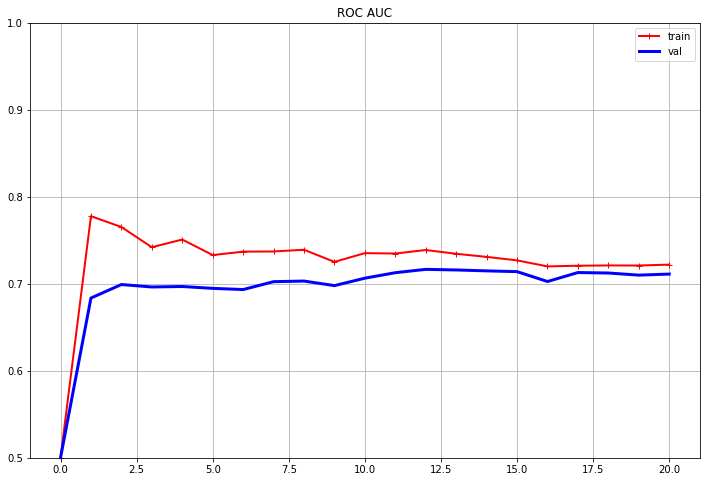

CPU times: user 1min 3s, sys: 98.9 ms, total: 1min 3s
Wall time: 1min 3s


In [ ]:
%%time
plot_learning_curve(XGBClassifier(random_state=42), roc_auc_score, final_train_X, final_train_y, final_val_X, final_val_y, M=750)

# 2 Bayesian optimization

In [ ]:
pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp36-none-any.whl size=11685 sha256=dba613acb1309fae3858fb7033e506a2b8379e7cac0a1a0098eda7aa9aca0ece
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


# Tuning XGB: the 1st time

In [ ]:
# reference: https://aiinpractice.com/xgboost-hyperparameter-tuning-with-bayesian-optimization/
from xgboost import XGBClassifier
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
# if necessary, specify "seed ="
pbounds = {
    'learning_rate': (0.1, 1.0),
    'n_estimators': (100, 500),
    'max_depth': (10, 100),
    'min_child_weight': (1, 10),
    'subsample': (0.5, 1.0),  # Change for big datasets
    'colsample': (0.5, 1.0),  # Change for datasets with lots of features
    'gamma': (0, 50)}

# ATTENTION: Must change the arguments in the following function after one revises the pbounds!
def xgboost_hyper_param(learning_rate, n_estimators, max_depth, min_child_weight, subsample, colsample, gamma):
  max_depth = int(max_depth)
  n_estimators = int(n_estimators)

  clf = XGBClassifier(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth, min_child_weight=min_child_weight, 
                      subsample=subsample, colsample=colsample, gamma=gamma)
  return_val = cross_val_score(clf, final_train_X, final_train_y, cv=5, scoring='roc_auc')  # roc_auc
  to_return = return_val.mean()
  return to_return

optimizer = BayesianOptimization(
    f = xgboost_hyper_param,
    pbounds = pbounds,
    random_state = 42,
)

In [ ]:
%%time
# to change n_iter to 15
optimizer.maximize(n_iter=15, init_points=2)

|   iter    |  target   | colsample |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.7842   |  0.6873   |  47.54    |  0.7588   |  63.88    |  2.404    |  162.4    |  0.529    |
|  2        |  0.7918   |  0.9331   |  30.06    |  0.7373   |  11.85    |  9.729    |  433.0    |  0.6062   |
|  3        |  0.7854   |  0.6016   |  45.98    |  0.9234   |  99.03    |  8.867    |  499.1    |  0.6223   |
|  4        |  0.7352   |  0.9872   |  0.5929   |  0.826    |  10.46    |  3.266    |  473.2    |  0.717    |
|  5        |  0.7883   |  0.5174   |  50.0     |  0.2559   |  100.0    |  10.0     |  320.6    |  0.6462   |
|  6        |  0.7938   |  0.8825   |  27.0     |  0.1541   |  14.72    |  8.249    |  432.3    |  0.944    |
|  7        |  0.7707   |  0.5596   |  1.807    |  0.625    |  13.98    |  7.888    |  104.4    |  0.7128   |
|  8      

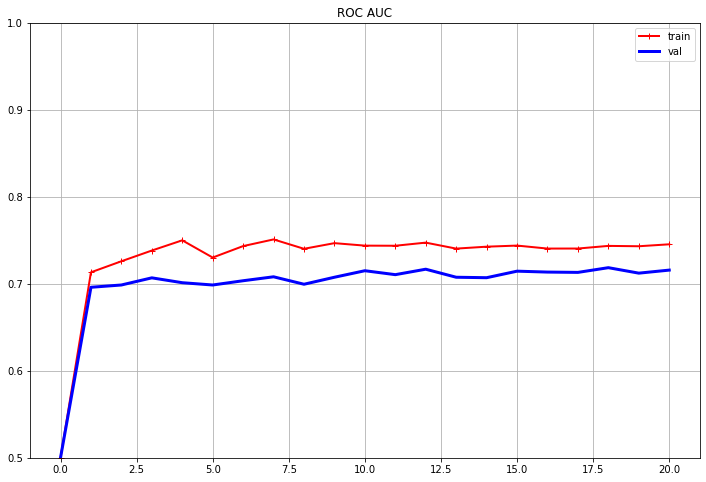

CPU times: user 14min 56s, sys: 757 ms, total: 14min 57s
Wall time: 14min 58s


In [ ]:
%%time
from sklearn.metrics import roc_auc_score

my_model = XGBClassifier(colsample=0.9472,
                         gamma=7.582,
                         learning_rate=0.2604, 
                         max_depth=int(99.31), 
                         min_child_weight=9.734,
                         n_estimators=int(233.8), 
                         subsample=0.593)

plot_learning_curve(my_model, roc_auc_score, final_train_X, final_train_y, final_val_X, final_val_y, M=750)

# Tuning XGB: the 2nd time

In [ ]:
# revise pbounds according to the previous optimization result
# if necessary, specify "seed ="
pbounds = {
    'learning_rate': (0.1, 0.5),
    'n_estimators': (150, 350),
    'max_depth': (80, 120),
    'min_child_weight': (8, 12),
    'subsample': (0.45, 0.75),   # Change for big datasets
    'colsample': (0.85, 1.0),    # Change for datasets with lots of features
    'gamma': (5, 10)}

# ATTENTION: Must change the arguments in the following function after one revises the pbounds!
def xgboost_hyper_param(learning_rate, n_estimators, max_depth, min_child_weight, subsample, colsample, gamma):
  max_depth = int(max_depth)
  n_estimators = int(n_estimators)

  clf = XGBClassifier(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth, min_child_weight=min_child_weight, 
                      subsample=subsample, colsample=colsample, gamma=gamma)
  return_val = cross_val_score(clf, final_train_X, final_train_y, cv=5, scoring='roc_auc')  # roc_auc
  to_return = return_val.mean()
  return to_return

optimizer = BayesianOptimization(
    f = xgboost_hyper_param,
    pbounds = pbounds,
    random_state = 42,
)

In [ ]:
%%time
# to change n_iter to 15
optimizer.maximize(n_iter=15, init_points=2)

|   iter    |  target   | colsample |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.7986   |  0.9062   |  9.754    |  0.3928   |  103.9    |  8.624    |  181.2    |  0.4674   |
|  2        |  0.7973   |  0.9799   |  8.006    |  0.3832   |  80.82    |  11.88    |  316.5    |  0.5137   |
|  3        |  0.798    |  0.9052   |  7.055    |  0.4126   |  80.59    |  10.64    |  150.0    |  0.4689   |
|  4        |  0.7979   |  0.8757   |  9.025    |  0.3208   |  119.8    |  11.02    |  349.0    |  0.7172   |
|  5        |  0.7988   |  0.906    |  5.922    |  0.2286   |  120.0    |  11.76    |  150.8    |  0.683    |
|  6        |  0.7991   |  0.9355   |  9.803    |  0.3796   |  118.4    |  11.48    |  150.5    |  0.7153   |
|  7        |  0.8      |  0.9805   |  8.697    |  0.1467   |  119.7    |  9.166    |  150.1    |  0.4877   |
|  8      

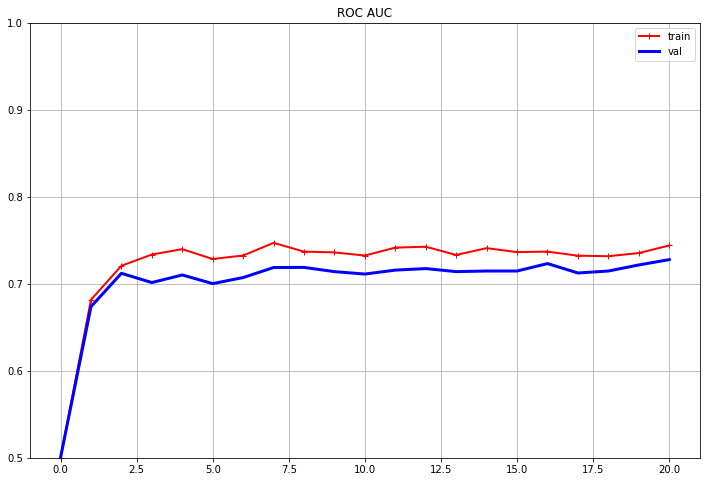

CPU times: user 8min 27s, sys: 432 ms, total: 8min 28s
Wall time: 8min 28s


In [ ]:
%%time
from sklearn.metrics import roc_auc_score

my_model = XGBClassifier(colsample=0.9805,
                         gamma=8.697,
                         learning_rate=0.1467, 
                         max_depth=int(119.7), 
                         min_child_weight=9.166,
                         n_estimators=int(150.1), 
                         subsample=0.4877)

plot_learning_curve(my_model, roc_auc_score, final_train_X, final_train_y, final_val_X, final_val_y, M=750)

# Tuning XGB: the 3rd time

In [ ]:
# revise pbounds according to the previous optimization result
# if necessary, specify "seed ="
pbounds = {
    'learning_rate': (0.1, 0.25),
    'n_estimators': (150, 200),
    'max_depth': (110, 130),
    'min_child_weight': (8, 11),
    'subsample': (0.45, 0.55),   # Change for big datasets
    'colsample': (0.95, 1.0),    # Change for datasets with lots of features
    'gamma': (7.5, 10)}

# ATTENTION: Must change the arguments in the following function after one revises the pbounds!
def xgboost_hyper_param(learning_rate, n_estimators, max_depth, min_child_weight, subsample, colsample, gamma):
  max_depth = int(max_depth)
  n_estimators = int(n_estimators)

  clf = XGBClassifier(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth, min_child_weight=min_child_weight, 
                      subsample=subsample, colsample=colsample, gamma=gamma)
  return_val = cross_val_score(clf, final_train_X, final_train_y, cv=5, scoring='roc_auc')  # roc_auc
  to_return = return_val.mean()
  return to_return

optimizer = BayesianOptimization(
    f = xgboost_hyper_param,
    pbounds = pbounds,
    random_state = 42,
)

In [ ]:
%%time
# to change n_iter to 15
optimizer.maximize(n_iter=15, init_points=2)

|   iter    |  target   | colsample |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.8003   |  0.9687   |  9.877    |  0.2098   |  122.0    |  8.468    |  157.8    |  0.4558   |
|  2        |  0.799    |  0.9933   |  9.003    |  0.2062   |  110.4    |  10.91    |  191.6    |  0.4712   |
|  3        |  0.7991   |  0.9792   |  7.846    |  0.1819   |  129.9    |  9.696    |  150.1    |  0.5433   |
|  4        |  0.7996   |  0.9586   |  9.513    |  0.1828   |  129.9    |  10.27    |  199.7    |  0.5391   |
|  5        |  0.7996   |  0.9668   |  7.584    |  0.215    |  110.1    |  8.513    |  150.2    |  0.4678   |
|  6        |  0.7994   |  0.9831   |  8.712    |  0.1625   |  110.2    |  10.16    |  199.8    |  0.5241   |
|  7        |  0.8008   |  0.9935   |  9.349    |  0.1175   |  129.8    |  8.875    |  150.0    |  0.4626   |
|  8      

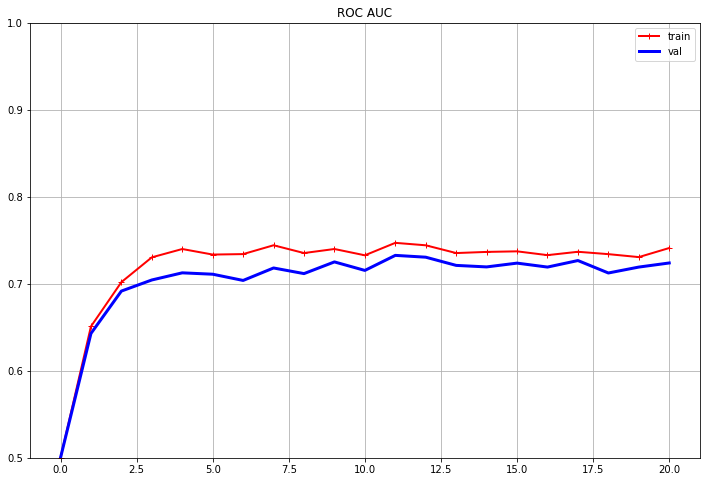

CPU times: user 8min 6s, sys: 455 ms, total: 8min 7s
Wall time: 8min 7s


In [ ]:
%%time
from sklearn.metrics import roc_auc_score

my_model = XGBClassifier(colsample=0.9935,
                         gamma=9.349,
                         learning_rate=0.1175, 
                         max_depth=int(129.8), 
                         min_child_weight=8.875,
                         n_estimators=int(150.0), 
                         subsample=0.4626)

plot_learning_curve(my_model, roc_auc_score, final_train_X, final_train_y, final_val_X, final_val_y, M=750)


# Which Factor Contributes Strongly to Prediction

Feature: city_development_index, Score: 0.15942
Feature: x0_NA_companyType, Score: 0.00253
Feature: x0_Public Sector, Score: 0.00112
Feature: x0_Pvt Ltd  , Score: 0.00382
Feature: x1_10/49    , Score: 0.00141
Feature: x1_10000+   , Score: 0.00056
Feature: x1_NA_companySize, Score: 0.05416
Feature: x2_NA_majorDiscipline, Score: 0.00433
Feature: x3_Has relevent experience, Score: 0.00362
Feature: x4_100      , Score: 0.00097
Feature: x4_103      , Score: 0.00421
Feature: x4_160      , Score: 0.00103
Feature: x5_1        , Score: 0.00226
Feature: x5_2        , Score: 0.00099
Feature: x5_4        , Score: 0.00095
Feature: x5_>4       , Score: 0.00093
Feature: x5_never    , Score: 0.00287
Feature: x6_1        , Score: 0.00062
Feature: x6_3        , Score: 0.00074
Feature: x6_<1       , Score: 0.00077
Feature: x6_>20      , Score: 0.00278
Feature: x7_Graduate , Score: 0.00453
Feature: x7_Masters  , Score: 0.00075
Feature: x8_Full time course, Score: 0.00218
Feature: x8_no_enrollment, Score: 

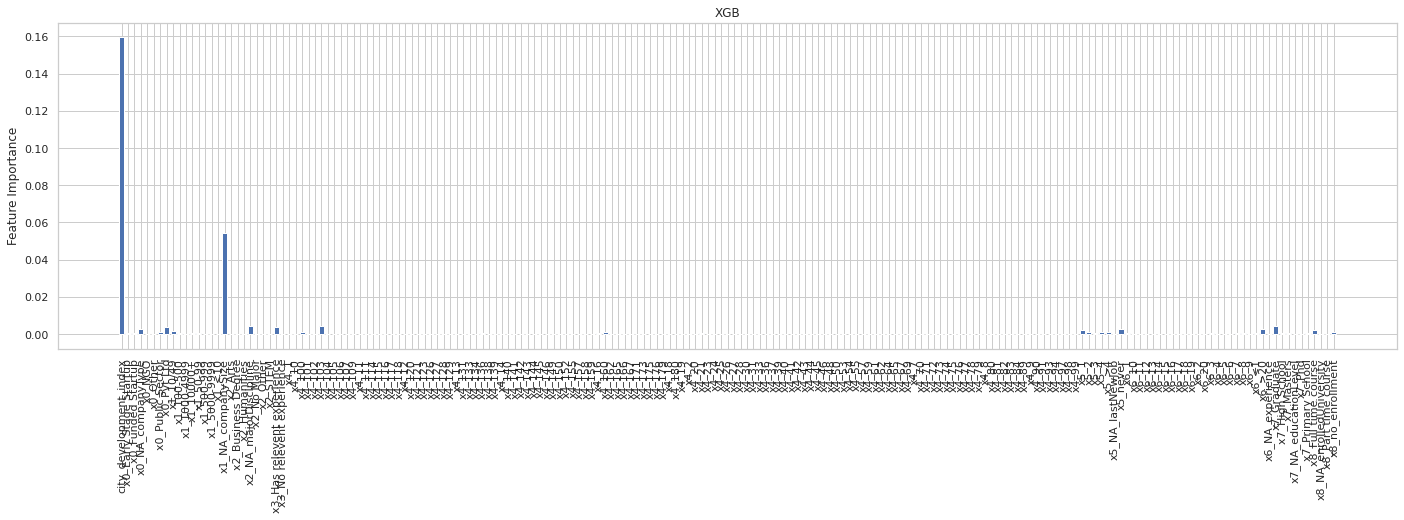

CPU times: user 2min 29s, sys: 613 ms, total: 2min 29s
Wall time: 2min 30s


In [ ]:
%%time
#Feature importance
print_features_importance('XGB', my_model, final_train_X, final_train_y)

The deciding factors are: city_development_index, company_type, company_size, major_discipline, relevent_experience, last_new_job, experience, education_level, and enrolled_university.

# Transform Test Data

In [ ]:
#test_raw = pd.read_csv("../input/?/test.csv")
#test_raw = pd.read_csv("/Users/shiningdu/Documents/?/test.csv")
#Mount your Google drive so you can read them easily
from google.colab import drive
drive.mount('/content/gdrive')
test_raw = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/HR Analytics- Job Change of Data Scientists/aug_test.csv")
test_raw.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15
3,27385,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,27724,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72


In [ ]:
test_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             2129 non-null   int64  
 1   city                    2129 non-null   object 
 2   city_development_index  2129 non-null   float64
 3   gender                  1621 non-null   object 
 4   relevent_experience     2129 non-null   object 
 5   enrolled_university     2098 non-null   object 
 6   education_level         2077 non-null   object 
 7   major_discipline        1817 non-null   object 
 8   experience              2124 non-null   object 
 9   company_size            1507 non-null   object 
 10  company_type            1495 non-null   object 
 11  last_new_job            2089 non-null   object 
 12  training_hours          2129 non-null   int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 216.4+ KB


In [ ]:
# how many percent of the observations contain at least one missing value?
len(test_raw[test_raw.isna().any(axis=1)])/len(test_raw)

0.5213715359323626

# Missing Value Imputation

In [ ]:
test_data = test_raw.copy()

test_data['company_type'].fillna('NA_companyType', inplace=True)
test_data['company_size'].fillna('NA_companySize', inplace=True)
test_data['gender'].fillna('NA_gender', inplace=True)
test_data['major_discipline'].fillna('NA_majorDiscipline', inplace=True)
test_data['education_level'].fillna('NA_educationLevel', inplace=True)
test_data['last_new_job'].fillna('NA_lastNewJob', inplace=True)
test_data['enrolled_university'].fillna('NA_enrolledUniversity', inplace=True)
test_data['experience'].fillna('NA_experience', inplace=True)

test_data.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NA_companyType,1,21
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NA_companySize,Pvt Ltd,1,98
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NA_majorDiscipline,<1,NA_companySize,Pvt Ltd,never,15
3,27385,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,27724,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72


In [ ]:
# how many percent of the observations contain at least one missing value NOW?
len(test_data[test_data.isna().any(axis=1)])/len(test_data)

0.0

In [ ]:
# Tackling the city feature
test_data2 = test_data.copy()

# to extract the value after "city_" in the city feature
import re
pattern = r'[0-9]+'
regex = re.compile(pattern)
f = lambda x: re.findall(regex, x)[0]    # [0] is used to obtain the value in brakets

test_data2['city'] = test_data2['city'].apply(f)

# to drop enrollee_id feature
#test_data2 =  test_data2.drop(['enrollee_id'], axis=1)

test_data2.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NA_companyType,1,21
1,9858,103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NA_companySize,Pvt Ltd,1,98
2,31806,21,0.624,Male,No relevent experience,no_enrollment,High School,NA_majorDiscipline,<1,NA_companySize,Pvt Ltd,never,15
3,27385,13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,27724,103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72


In [ ]:
Final_test = full_pipeline.transform(test_data2)

# Predict Using Test Data

In [ ]:
import joblib

my_model = XGBClassifier(colsample=0.9935,
                         gamma=9.349,
                         learning_rate=0.1175, 
                         max_depth=int(129.8), 
                         min_child_weight=8.875,
                         n_estimators=int(150.0), 
                         subsample=0.4626)

joblib.dump(my_model, "/content/gdrive/My Drive/Colab Notebooks/HR Analytics- Job Change of Data Scientists/best_XGB_Bayesian.pkl")

# to load this model later
#my_model_loaded = joblib.load("/.../best_XGB_Bayesian.pkl")

['/content/gdrive/My Drive/Colab Notebooks/HR Analytics- Job Change of Data Scientists/best_XGB_Bayesian.pkl']

In [ ]:
my_model.fit(final_train_X, final_train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample=0.9935,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=9.349, learning_rate=0.1175, max_delta_step=0,
              max_depth=129, min_child_weight=8.875, missing=None,
              n_estimators=150, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=0.4626, verbosity=1)

In [ ]:
test_prediction_XGB = my_model.predict(Final_test)

In [ ]:
type(test_prediction_XGB)

numpy.ndarray

In [ ]:
len(test_prediction_XGB)

2129

In [ ]:
test_prediction_XGB = pd.DataFrame(test_prediction_XGB)
test_prediction_XGB.columns = ['target']
final_test_prediction_XGB = pd.concat([test_data2, test_prediction_XGB], axis=1)
final_test_prediction_XGB.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,32403,41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NA_companyType,1,21,0
1,9858,103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NA_companySize,Pvt Ltd,1,98,0
2,31806,21,0.624,Male,No relevent experience,no_enrollment,High School,NA_majorDiscipline,<1,NA_companySize,Pvt Ltd,never,15,1
3,27385,13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39,0
4,27724,103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72,0


In [ ]:
prediction_returned = final_test_prediction_XGB[['enrollee_id', 'target']]

In [ ]:
prediction_returned.to_csv('/content/gdrive/My Drive/Colab Notebooks/HR Analytics- Job Change of Data Scientists/XGB_prediction_Feb23rd.csv', index=False)

Now the predicted data is saved in my drive.

# Conclusion

In this project I explore different models that predict if a candidate would seek position of data scientist. The deciding factors are: city_development_index, company_type, company_size, major_discipline, relevent_experience, last_new_job, experience, education_level, and enrolled_university.